### Import Library

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

import re
from tqdm import tqdm

### GPU checking

In [48]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14313342137121256199
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12126978316484945006
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [101]:
data = pd.read_csv("data/data.csv")

In [82]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_C,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.1,NaN,0.0,36.896198,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,"4,700",NaN,0.0,36.872700,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0


### Processing missing data & Drop unnecessary data

In [102]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

In [103]:
data = data.drop(['OBJECTID_x', 'ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve'], axis = 1)

### train / test split

In [104]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [105]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
As_train = train.drop(['Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['As','Cd','Ni','Pb','Hg'], axis=1)

test = test.drop(['As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [106]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166 entries, 1170 to 684
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1166 non-null   float64
 1   As              1166 non-null   float64
 2   slope           1166 non-null   float64
 3   altitude        1166 non-null   float64
 4   profile_c_num   1166 non-null   float64
 5   profile_c_abs   1166 non-null   int64  
 6   planform_c_num  1166 non-null   float64
 7   planform_c_abs  1166 non-null   int64  
 8   HYDGRP_A        1166 non-null   int64  
 9   HYDGRP_B        1166 non-null   int64  
 10  HYDGRP_C        1166 non-null   int64  
 11  HYDGRP_D        1166 non-null   int64  
 12  ANION_EXCL      1166 non-null   float64
 13  SOL_CRK         1166 non-null   float64
 14  SOL_K1          1166 non-null   float64
 15  CLAY1           1166 non-null   float64
 16  SILT1           1166 non-null   float64
 17  SAND1           1166 non-null  

In [88]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 411 to 40
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              292 non-null    float64
 1   slope           292 non-null    float64
 2   altitude        292 non-null    float64
 3   profile_c_num   292 non-null    float64
 4   profile_c_abs   292 non-null    int64  
 5   planform_c_num  292 non-null    float64
 6   planform_c_abs  292 non-null    int64  
 7   HYDGRP_A        292 non-null    int64  
 8   HYDGRP_B        292 non-null    int64  
 9   HYDGRP_C        292 non-null    int64  
 10  HYDGRP_D        292 non-null    int64  
 11  ANION_EXCL      292 non-null    float64
 12  SOL_CRK         292 non-null    float64
 13  SOL_K1          292 non-null    float64
 14  CLAY1           292 non-null    float64
 15  SILT1           292 non-null    float64
 16  SAND1           292 non-null    float64
 17  ROCK1           292 non-null    fl

### Check the value skewed

#### As

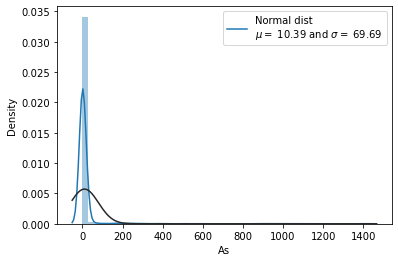

In [107]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

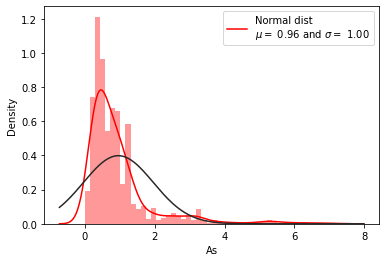

In [108]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

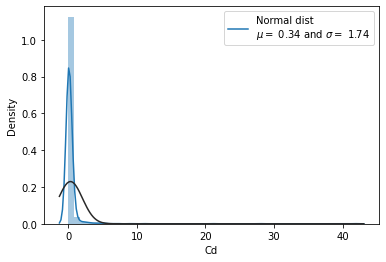

In [109]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

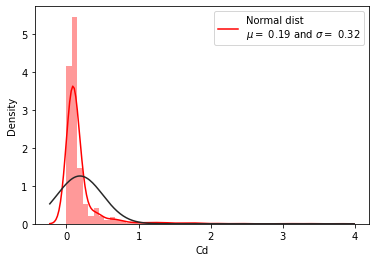

In [110]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

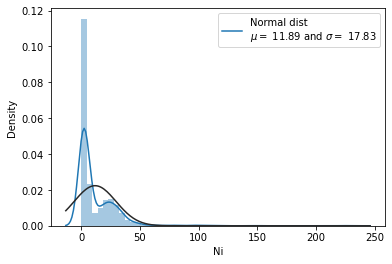

In [111]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

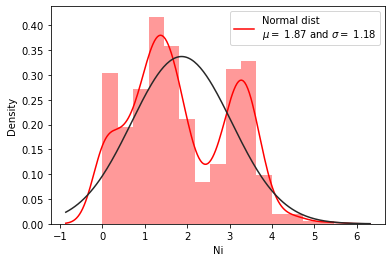

In [112]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [114]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

#### StandardScaling

In [116]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [117]:
scaler = StandardScaler()

As_X = pd.DataFrame(scaler.fit_transform(As_X), columns=As_X.columns)
Cd_X = pd.DataFrame(scaler.fit_transform(Cd_X), columns=Cd_X.columns)
Ni_X = pd.DataFrame(scaler.fit_transform(Ni_X), columns=Ni_X.columns)

#### 10-Fold Crossvalidation

In [118]:
kf = KFold(n_splits = 10, random_state = 605, shuffle = True)

#### 1) NGBRegressor

In [119]:
ngb = NGBRegressor(random_state = 605, verbose = 500, n_estimators = 500)

In [120]:
ngb_pred = np.zeros((test.shape[0]))
rmse_list = []

for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 10
    ngb_pred += sub_pred

print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

[iter 0] loss=1.4129 val_loss=0.0000 scale=1.0000 norm=0.9972
[iter 100] loss=1.0325 val_loss=0.0000 scale=2.0000 norm=1.5694
[iter 200] loss=0.8706 val_loss=0.0000 scale=1.0000 norm=0.7349
[iter 300] loss=0.7886 val_loss=0.0000 scale=1.0000 norm=0.7094
[iter 400] loss=0.7314 val_loss=0.0000 scale=1.0000 norm=0.6933
[iter 0] loss=0.8333 val_loss=0.0000 scale=1.0000 norm=0.7872
[iter 100] loss=0.7243 val_loss=0.0000 scale=1.0000 norm=0.7023
[iter 200] loss=0.6863 val_loss=0.0000 scale=0.5000 norm=0.3437
[iter 300] loss=0.6549 val_loss=0.0000 scale=1.0000 norm=0.6756
[iter 400] loss=0.6215 val_loss=0.0000 scale=0.5000 norm=0.3304
[iter 0] loss=0.5964 val_loss=0.0000 scale=1.0000 norm=0.6712
[iter 100] loss=0.5514 val_loss=0.0000 scale=0.5000 norm=0.3192
[iter 200] loss=0.5218 val_loss=0.0000 scale=0.5000 norm=0.3135
[iter 300] loss=0.4979 val_loss=0.0000 scale=1.0000 norm=0.6197
[iter 400] loss=0.4763 val_loss=0.0000 scale=1.0000 norm=0.6137
[iter 0] loss=0.5037 val_loss=0.0000 scale=1.0

#### 2) RandomForestRegressor

In [121]:
rf = RandomForestRegressor(random_state = 605, n_estimators = 150)

In [123]:
rf_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 10
    rf_pred += sub_pred

print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

RandomForestRegressor의 10fold 평균 RMSE는 54.6853576682375


#### 3) ExtraTreesRegressor

In [124]:
etc = ExtraTreesRegressor(random_state = 605, n_estimators = 500)

In [125]:
etc_pred = np.zeros((test.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(As_X, As_y) :
    tr_x, tr_y = As_X.iloc[tr_idx], As_y.iloc[tr_idx]
    val_x, val_y = As_X.iloc[val_idx], As_y.iloc[val_idx]
    
    etc.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 10
    etc_pred += sub_pred

print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

ExtraTreesRegressor의 10fold 평균 RMSE는 50.24894647593446


#### 4) GradientBoostingRegressor

In [126]:
gb = GradientBoostingRegressor(random_state = 605, max_depth = 5)

In [ ]:
gb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(target)]) / 10
    gb_pred += sub_pred
print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')